In [1]:
%matplotlib inline

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import scipy.io as sio


In [452]:
data = np.load("data_img.npy")
labels = np.load("labels_img.npy")

In [454]:
labels.shape

(549,)

# Build decoder

In [9]:
%matplotlib inline
import os
import yaml
import matplotlib.gridspec as gridspec
import math
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [7]:
# from tensorboardX import SummaryWriter
# from torchvision import datasets, transforms
# from torchvision.utils import make_grid
from tqdm import tqdm, trange

# writer = SummaryWriter()
# sns.set()
# sns.set_style("dark")
# sns.set_palette("muted")
# sns.set_color_codes("muted")

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

True


In [275]:
BATCH_SIZE = 32

CLASSES = 2
TRAIN_EPOCHS = 100



In [276]:
decision_data = data[~np.isnan(labels)]
decision_labels = labels[~np.isnan(labels)]

In [277]:
decision_data = decision_data.reshape((decision_data.shape[0], 1, decision_data.shape[1], decision_data.shape[2]))

In [279]:
decision_labels = decision_labels - 1

In [281]:
idx = np.random.choice(decision_labels.shape[0], decision_labels.shape[0], replace = False)
decision_labels = decision_labels[idx]
decision_data = decision_data[idx]

In [293]:
training_samples = 500

In [295]:
train_data = torch.tensor(decision_data[:training_samples])
tensor_train_labels = torch.tensor(decision_labels[:training_samples])
test_data = torch.tensor(decision_data[training_samples:])
tensor_test_labels = torch.tensor(decision_labels[training_samples:])

In [296]:
torch_train_dataset = torch.utils.data.TensorDataset(train_data, tensor_train_labels)
train_loader = torch.utils.data.DataLoader(torch_train_dataset, batch_size=BATCH_SIZE)
torch_test_dataset = torch.utils.data.TensorDataset(test_data, tensor_test_labels)
test_loader = torch.utils.data.DataLoader(torch_test_dataset, batch_size=BATCH_SIZE)

In [297]:
TRAIN_SIZE = len(train_loader.dataset)
NUM_BATCHES = len(train_loader)

In [298]:
NUM_BATCHES

16

In [391]:
class Net(nn.Module):   
    def __init__(self, ):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 3, kernel_size=(7, 3), stride=(3, 1), padding=3),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
#             nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(3),
#             nn.Tanh(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(3),
#             nn.Tanh(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(975, 64), 
#             nn.BatchNorm1d(64),
            nn.Tanh(),
#             nn.Linear(128, 64), 
#             nn.Tanh(),
            nn.Linear(64, 16), 
            nn.Tanh(),
            nn.Linear(16, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 2), 
            # Dimension?
            nn.Softmax(dim = 1)
        )

    # Defining the forward pass    
    def forward(self, x):
#         print(self.cnn_layers[0](x).shape)
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [440]:
def train(model, optimizer, epoch, l2_regularization = True):
    model.train()

    #     if epoch == 0: # write initial distributions
    #         write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate((train_loader)):
    #         data = data.reshape((data.shape[0], 1, data.shape[1])).float()
    #         target = target.reshape(target.shape[0])
    #         data, target = data.cuda(), target.cuda()
        target = target.long()
        optimizer.zero_grad()
        output_val = model(data)
        loss = criterion(output_val, target)
        if l2_regularization:
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
                l2_reg += 0.01*torch.norm(param)
        loss += l2_reg
        loss.backward()
        optimizer.step()
    return loss



In [441]:
# defining the model
model = Net()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 3, kernel_size=(7, 3), stride=(3, 1), padding=(3, 3))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=975, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Softmax(dim=1)
  )
)


In [442]:
TRAIN_EPOCHS = 100
loss_overtime = []
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
for epoch in tqdm(range(TRAIN_EPOCHS)):
    loss  = train(model, optimizer, epoch)
    loss_overtime.append(loss.detach().numpy())
    if epoch % 5 == 0:
        plt.figure(figsize = (10, 10))
        plt.plot(loss_overtime)
        plt.grid()
        plt.savefig("loss_overtime.png")
        plt.close()
    if (epoch+1) % 10 == 0:
        scheduler.step()
#         for param_group in optimizer.param_groups:
#             print(param_group['lr'])

 10%|█         | 10/100 [00:07<01:08,  1.31it/s]

0.00025


 20%|██        | 20/100 [00:15<01:01,  1.31it/s]

0.000125


 30%|███       | 30/100 [00:23<00:53,  1.32it/s]

6.25e-05


 40%|████      | 40/100 [00:31<00:45,  1.31it/s]

3.125e-05


 50%|█████     | 50/100 [00:39<00:38,  1.31it/s]

1.5625e-05


 60%|██████    | 60/100 [00:47<00:30,  1.31it/s]

7.8125e-06


 70%|███████   | 70/100 [00:54<00:20,  1.46it/s]

3.90625e-06


 80%|████████  | 80/100 [01:01<00:15,  1.33it/s]

1.953125e-06


 90%|█████████ | 90/100 [01:09<00:07,  1.31it/s]

9.765625e-07


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]

4.8828125e-07


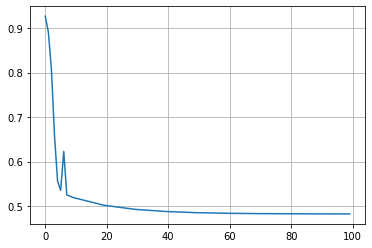

In [447]:
plt.plot(loss_overtime)
plt.grid()

In [448]:
####### evaluate on train 

model.eval()
train_loss = 0
for batch_idx, (data, target) in enumerate((train_loader)):
    output_val = model(data)
#     print("difference")
#     print((output_val.detach().numpy().argmax(1) - target.detach().numpy()))
#     print("train loss")
#     print(((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean())
    train_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
train_loss = train_loss/TRAIN_SIZE
print(train_loss)

0.004


In [449]:
model.eval()
test_loss = 0
for batch_idx, (data, target) in enumerate((test_loader)):
    output_val = model(data)
    print("difference")
    print((output_val.detach().numpy().argmax(1) - target.detach().numpy()))
    print("test loss")
    print(((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean())
    test_loss += ((output_val.detach().numpy().argmax(1) - target.detach().numpy())**2).mean()*data.shape[0]
test_loss = test_loss/48

difference
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1.]
test loss
0.09375
difference
[ 0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
test loss
0.1875


In [450]:
test_loss

0.125